In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# I have experienced stability issues with float32.
from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit

import jaxley as jx
from jaxley.channels import HH
from jaxley.synapses import IonotropicSynapse
from jaxley.connection import fully_connect

### Setup

In [4]:
# Number of segments per branch.
nseg_per_branch = 8

# Stimulus.
i_delay = 3.0  # ms
i_amp = 0.05  # nA
i_dur = 2.0  # ms

# Duration and step size.
dt = 0.025  # ms
t_max = 50.0  # ms

In [5]:
time_vec = jnp.arange(0.0, t_max + dt, dt)

### Define compartment and branch

In [6]:
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=nseg_per_branch)

### Define cell

Below, we define the morphology. Each element of `parents` corresponds to one branch. A `-1` entry means that this branch does not have a parent. Alternatively, you could also load cells from SWC with 

```cell = jx.read_swc(fname, nseg=4)```.

In [7]:
num_branches = 15
parents = jnp.asarray([-1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6])
assert len(parents) == num_branches

In [8]:
cell = jx.Cell(branch, parents=parents)

Cells can be visualized as follows:

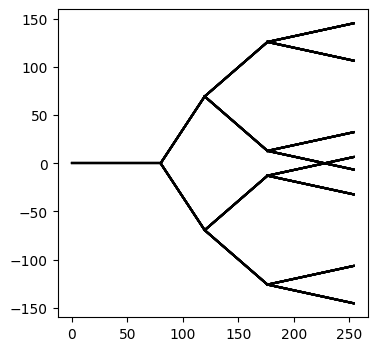

In [9]:
cell.compute_xyz()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
_ = cell.vis(ax=ax)

### Define connectivity

In this case, two layers fully connected.

In [10]:
num_cells = 16

In [11]:
network = jx.Network([cell for _ in range(num_cells)])

In [12]:
# Layer 1
pre = network.cell([0, 1, 2, 3, 4])
post = network.cell(np.arange(5, 15).tolist())
fully_connect(pre, post, IonotropicSynapse())

# Layer 2
pre = network.cell(np.arange(5, 15).tolist())
post = network.cell(15)
fully_connect(pre, post, IonotropicSynapse())

/home/kyra/Documents/Jaxley/jaxley/jaxley/modules/base.py:1432: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.pointer.edges = pd.concat(


Networks can be visualized as point neurons:

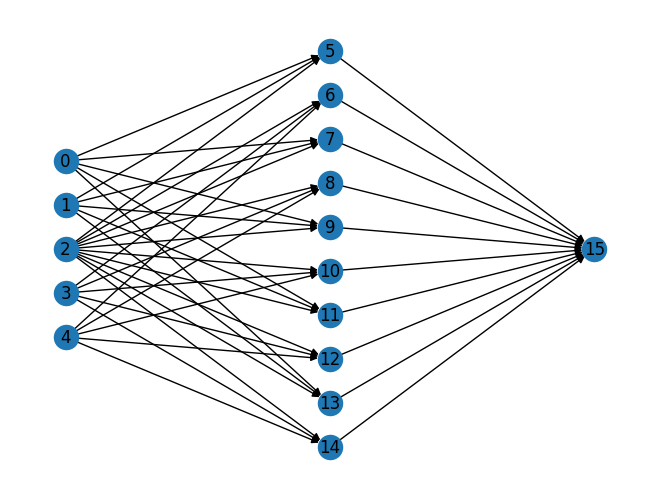

In [13]:
network.vis(detail="point", layers=[5, 10, 1])

But they can also be visualized with full morphological detail.

<Axes: >

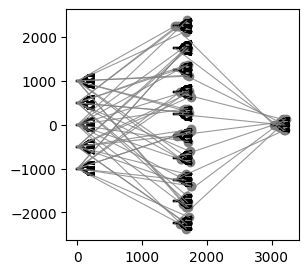

In [14]:
network.vis(
    detail="full",
    layers=[5, 10, 1],
    synapse_col="gray",
    synapse_plot_kwargs={"alpha": 0.8, "linewidth": 0.8},
)

For more control over where the neurons are located in the plot, `move()` or `move_to()` can be used.

In [15]:
for i in range(5):
    network.cell(i).move_to(x=0, y=200 * i)

for i in range(5, 15):
    network.cell(i).move_to(x=400, y=200 * i - 1500)

for i in range(15, 16):
    network.cell(i).move_to(x=800, y=500)

<Axes: >

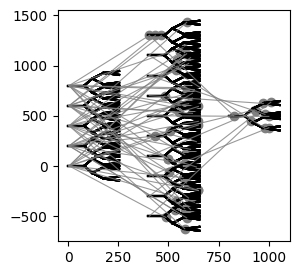

In [16]:
network.vis(
    detail="full",
    synapse_col="gray",
    synapse_plot_kwargs={"alpha": 0.8, "linewidth": 0.8},
)

### Insert mechanisms

In [17]:
network.insert(HH())

### Define stimuli and recordings

In [18]:
for cell_ind in range(num_cells):
    network.cell(cell_ind).branch(0).loc(0.0).record()

current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
for stim_ind in range(5):
    network.cell(stim_ind).branch(0).loc(0.0).stimulate(current)

Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 stimuli. See `.currents` for details.
Added 1 stimuli. See `.currents` for details.
Added 1 stimuli. See `.currents` for details.
Added 1 stimuli. See `.currents` for details.


### Solve ODE

In [19]:
%%time
s = jx.integrate(network, delta_t=dt)

CPU times: user 3.39 s, sys: 87 ms, total: 3.48 s
Wall time: 3.39 s


### jit compilation

We can jit-compile the simulation in order to make it faster. The code below will be slow when run for the first time, but fast upon the second run.

In [20]:
def run_sim():
    return jx.integrate(network, delta_t=dt)


jitted_run_sim = jit(run_sim)

In [21]:
%%time
s = jitted_run_sim()

CPU times: user 2.57 s, sys: 6.9 ms, total: 2.58 s
Wall time: 2.58 s


### Visualize traces

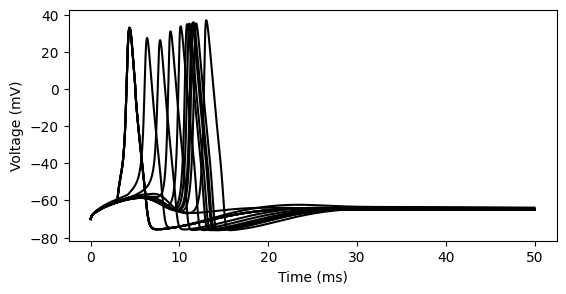

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6.3, 3))
for i in range(num_cells):
    _ = ax.plot(time_vec, s[i][:-1], c="k")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Voltage (mV)")
plt.show()